In [1]:
from src.main import generate_corrupted_dataset

data = generate_corrupted_dataset(n_customers=20, years=5)

/Users/paulwilliamson/synthetic_transactions/src/corruptors/base.py:70: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  contract_ammendments = contract_ammendments.stack("customer_id").reset_index(drop=False)
/Users/paulwilliamson/synthetic_transactions/src/corruptors/base.py:87: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["flag_missing_charges"] = df["flag_missing_charges"].fillna(False)


In [2]:
data.columns

Index(['date', 'customer_id', 'order_number', 'item_category_id', 'service_id',
       'variant', 'price', 'quantity', 'final_price', 'new_customer',
       'contract_ammendment', 'condition_1_price', 'condition_2_probability',
       'condition_3_price', 'condition_3_probability',
       'condition_4_probability', 'flag_random_price_change',
       'flag_condition_not_implemented', 'flag_price_change_no_ammendment',
       'flag_missing_charges', 'flag_discrepancy'],
      dtype='object')

In [4]:
data.filter(like="flag_").mean()

flag_random_price_change           0.029695
flag_condition_not_implemented     0.021577
flag_price_change_no_ammendment    0.000371
flag_missing_charges               0.049871
flag_discrepancy                   0.098071
dtype: float64

# Programmatic Detection: 
- flag_random_price_change
- flag_price_change_no_ammendment

In [61]:
data_copy = data.copy()

price_changes = data_copy.copy()
price_changes["service_composite"] = price_changes["service_id"].astype(str) + "_" + price_changes["variant"].astype(str)

price_changes = (
    price_changes[["date", "customer_id", "order_number", "service_composite", "price"]]
    .set_index(["date", "customer_id", "order_number", "service_composite"])
)
price_changes = price_changes.groupby(["date", "customer_id", "service_composite"]).mean()

price_changes = price_changes.unstack(["customer_id", "service_composite"]).ffill().bfill().diff()

price_changes = price_changes.stack(["customer_id", "service_composite"])

price_changes.loc[price_changes["price"].abs() > 0, "price"] = True
price_changes.loc[price_changes["price"].abs() == 0, "price"] = False

price_changes = price_changes.groupby(["date", "customer_id"]).max()
price_changes.rename(columns={"price": "CLS_price_change"}, inplace=True)

price_changes.reset_index(drop=False, inplace=True)

output = data_copy.merge(price_changes, on=["date", "customer_id"], how="left")
output["CLS_price_change"] = output["CLS_price_change"].fillna(False)

output = (
    output[
        ["date", "customer_id", "contract_ammendment", "flag_price_change_no_ammendment", "flag_random_price_change", "CLS_price_change"]
    ]
    .groupby(["date", "customer_id"]).max()
)
output.loc[output["contract_ammendment"]==True, "CLS_price_change"] = False

output = output[["flag_price_change_no_ammendment", "flag_random_price_change", "CLS_price_change"]]

/var/folders/41/81ppdf3x65x9r8sjcybxdq380000gn/T/ipykernel_5158/2605581385.py:14: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  price_changes = price_changes.stack(["customer_id", "service_composite"])
/var/folders/41/81ppdf3x65x9r8sjcybxdq380000gn/T/ipykernel_5158/2605581385.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  price_changes.loc[price_changes["price"].abs() > 0, "price"] = True
/var/folders/41/81ppdf3x65x9r8sjcybxdq380000gn/T/ipykernel_5158/2605581385.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Cal

In [62]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def metrics(y_true, y_pred):
    return {
        "accuracy": round(accuracy_score(y_true, y_pred), 4),
        "recall": round(recall_score(y_true, y_pred), 4),
        "precision": round(precision_score(y_true, y_pred), 4),
        "f1": round(f1_score(y_true, y_pred), 4)
    }

output["combined_true"] = output["flag_price_change_no_ammendment"] | output["flag_random_price_change"]

for col in ["flag_price_change_no_ammendment", "flag_random_price_change", "combined_true"]:
    print(f"Metrics for {col}")
    print(metrics(output[col], output["CLS_price_change"]), "\n")

Metrics for flag_price_change_no_ammendment
{'accuracy': 0.6264, 'recall': 0.7895, 'precision': 0.0009, 'f1': 0.0018} 

Metrics for flag_random_price_change
{'accuracy': 0.7482, 'recall': 0.9925, 'precision': 0.329, 'f1': 0.4942} 

Metrics for combined_true
{'accuracy': 0.7484, 'recall': 0.9918, 'precision': 0.3299, 'f1': 0.4951} 



In [63]:
output_copy = output.copy()

output_copy["mm-yyyy"] = output_copy.index.get_level_values("date").strftime("%m-%Y")
output_copy = output_copy.groupby("mm-yyyy").max()

for col in ["flag_price_change_no_ammendment", "flag_random_price_change", "combined_true"]:
    print(f"Metrics for {col}")
    print(metrics(output_copy[col], output_copy["CLS_price_change"]), "\n")

Metrics for flag_price_change_no_ammendment
{'accuracy': 0.2083, 'recall': 1.0, 'precision': 0.2083, 'f1': 0.3448} 

Metrics for flag_random_price_change
{'accuracy': 1.0, 'recall': 1.0, 'precision': 1.0, 'f1': 1.0} 

Metrics for combined_true
{'accuracy': 1.0, 'recall': 1.0, 'precision': 1.0, 'f1': 1.0} 



In [64]:
output_copy = output.copy()

output_copy["yyyy-week_no"] = output_copy.index.get_level_values("date").strftime("%Y-%U")
output_copy = output_copy.groupby("yyyy-week_no").max()

for col in ["flag_price_change_no_ammendment", "flag_random_price_change", "combined_true"]:
    print(f"Metrics for {col}")
    print(metrics(output_copy[col], output_copy["CLS_price_change"]), "\n")

Metrics for flag_price_change_no_ammendment
{'accuracy': 0.0473, 'recall': 1.0, 'precision': 0.0473, 'f1': 0.0904} 

Metrics for flag_random_price_change
{'accuracy': 1.0, 'recall': 1.0, 'precision': 1.0, 'f1': 1.0} 

Metrics for combined_true
{'accuracy': 1.0, 'recall': 1.0, 'precision': 1.0, 'f1': 1.0} 



# Programmatic Detection:
- flag_condition_not_implemented
- NOTE: in reality there is an obscured pain point here on where the condition isn't implemented correctly in the reconciliation system, such as incorrect % or price changes. 
- This programmatic method would not detect this pain point.

In [108]:
data_copy = data.copy()

price_cond_cols = data_copy.filter(like="condition_").filter(like="price").columns

data_copy["cond_diff_price"] = data_copy["final_price"] - (data_copy["price"] * data_copy["quantity"])
data_copy["cond_evidence"] = data_copy["cond_diff_price"].abs() > 0
data_copy["price_cond_active"] = data_copy[price_cond_cols].any(axis=1)
data_copy["CLS_price_condition"] = data_copy["price_cond_active"] & (~data_copy["cond_evidence"])

data_copy = data_copy[["cond_evidence", "price_cond_active", "CLS_price_condition", "flag_condition_not_implemented"]]

print(metrics(data_copy["flag_condition_not_implemented"], data_copy["CLS_price_condition"]), "\n")

{'accuracy': 0.9959, 'recall': 0.8094, 'precision': 1.0, 'f1': 0.8947} 



# Autoencoder Detection:
- flag_missing_charges

In [167]:
data_copy = data.copy()

cond_proba_cols = data_copy.filter(like="condition_").filter(like="proba").columns.tolist()

data_copy = data_copy[["date", "customer_id", "order_number", "service_id", "variant"] + cond_proba_cols]
characteristics = data_copy[["date", "customer_id", "order_number", "service_id", "variant"] + cond_proba_cols].drop_duplicates().copy()

items = data_copy[["date", "customer_id", "order_number", "service_id", "variant"]].copy()
items.fillna({"variant": 0}, inplace=True)
items["product_composite"] = items["service_id"].astype(str) + "_" + items["variant"].astype(str)
items.drop(columns=["service_id", "variant"], inplace=True)
items["present"] = True

items = items.drop_duplicates()

items.set_index(["date", "customer_id", "order_number", "product_composite"], inplace=True)
items = items.unstack("product_composite").reset_index(drop=False)

def drop_multi_index(col: tuple):
    return col[1] if col[1] != "" else col[0]

items.columns = [drop_multi_index(col) for col in items.columns]

items.fillna(False, inplace=True)

full_dataset = characteristics.merge(items, on=["date", "customer_id", "order_number"], how="left")

full_dataset = full_dataset.merge(
    data[["date", "customer_id", "order_number", "flag_missing_charges"]].drop_duplicates(),
    on=["date", "customer_id", "order_number"], how="left"
)

full_dataset.drop(columns=["service_id", "variant"], inplace=True)

/var/folders/41/81ppdf3x65x9r8sjcybxdq380000gn/T/ipykernel_5158/1041620390.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  items.fillna({"variant": 0}, inplace=True)
/var/folders/41/81ppdf3x65x9r8sjcybxdq380000gn/T/ipykernel_5158/1041620390.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  items.fillna(False, inplace=True)


In [168]:
index_cols = ["date", "customer_id", "order_number"]
customer_cols = ["customer_id"]
characteristic_cols = full_dataset.filter(like="condition_").columns.tolist()
target_cols = ["flag_missing_charges"]
item_cols = [x for x in full_dataset.columns if x not in index_cols + characteristic_cols + target_cols]

In [169]:
import category_encoders as ce

ce_be = ce.BinaryEncoder(cols=['customer_id'], )
cust_encodings = ce_be.fit_transform(full_dataset[['customer_id']])

full_dataset = full_dataset.merge(cust_encodings, left_index=True, right_index=True)

In [178]:
encoded_customer_cols = full_dataset.filter(like="customer_id_").columns.tolist()
features = encoded_customer_cols + characteristic_cols + item_cols

In [194]:
X = full_dataset[["date"] + features + target_cols]
X = X[X[target_cols[0]]==False]
dates = X["date"].unique()
X.set_index("date", inplace=True)

val_split = 0.7
test_split = 0.8
train_dates = dates[:int(len(dates) * val_split)]
val_dates = dates[int(len(dates) * val_split):int(len(dates) * test_split)]
test_dates = dates[int(len(dates) * test_split):]

X_train = X.loc[train_dates].astype(int)
X_val = X.loc[val_dates].astype(int)
X_test = X.loc[test_dates].astype(int)

In [ ]:
import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset

class Encoder(nn.Module):

    def __init__(
            self,
            n_features: int,
            n_products: int,
            hidden_size: int,
        ):
        super(Encoder, self).__init__()
        self.n_features = n_features
        self.n_products = n_products
        self.hidden_size = hidden_size

        self.encoder = nn.Sequential(
            nn.Linear(n_features, hidden_size),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.encoder(x)
    

class Decoder(nn.Module):
    
    def __init__(
            self,
            n_features: int,
            n_products: int,
            hidden_size: int,
        ):
        super(Decoder, self).__init__()
        self.n_features = n_features
        self.n_products = n_products
        self.hidden_size = hidden_size

        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, n_products),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.decoder(x)
    

class Autoencoder(nn.Module):
    
    def __init__(
            self,
            n_features: int,
            n_products: int,
            hidden_size: int,
        ):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(n_features, n_products, hidden_size)
        self.decoder = Decoder(n_features, n_products, hidden_size)

    def forward(self, x):
        return self.decoder(self.encoder(x))
    
    def predict(self, X: pd.DataFrame, features: list[str], targets: list[str], batch_size: int = 32, device: str = "cpu") -> np.ndarray:
        self.to(device)
        loader = DataLoader(AEDataset(X, features, targets), batch_size=batch_size, shuffle=False)
        predictions = []
        with torch.no_grad():
            for inputs, _ in loader:
                batch = inputs.float().to(device)
                output = self(batch).to("cpu")
                predictions.append(output)
        predictions = torch.cat(predictions, dim=0)
        self.to("cpu")
        return predictions.detach().numpy()
    

class AEDataset(Dataset):
    
    def __init__(self, X: pd.DataFrame, features: list[str], targets: list[str]):
        self.X = X[features].values
        self.y = X[targets].values

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # return torch.tensor(self.X[idx])
        return (
            torch.tensor(self.X[idx]), torch.tensor(self.y[idx])
        )
    

def train_model(
        model: nn.Module,
        X_train: torch.Tensor,
        X_val: torch.Tensor,
        features: list[str],
        targets: list[str],
        dataset: Dataset,
        criterion: nn.Module = nn.BCELoss,
        optimizer: torch.optim.Optimizer = torch.optim.Adam,
        n_epochs: int = 100,
        lr: float = 1e-3,
        batch_size: int = 32,
        device: str = "mps",
        patience: int = 5,
        save_loc: str = "./models/"
    ):
    model.to(device)
    criterion = criterion()
    optimizer = optimizer(model.parameters(), lr=lr)
    train_loader = DataLoader(dataset(X_train, features, targets), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset(X_val, features, targets), batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []
    best_val_loss = float("inf")
    patience_counter = 0
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            batch = inputs.float().to(device)
            output = model(batch)
            loss = criterion(output, targets.float().to(device))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                batch = inputs.float().to(device)
                output = model(batch)
                loss = criterion(output, targets.float().to(device))
                val_loss += loss.item()
            val_loss /= len(val_loader)
            val_losses.append(val_loss)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), save_loc + "model.pth")
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter == patience:
                    break

        print(f"Epoch {epoch + 1}/{n_epochs} - Train Loss: {train_loss / len(train_loader)} - Val Loss: {val_loss / len(val_loader)}")
    
    if os.path.exists(save_loc + "model.pth"):
        model.load_state_dict(torch.load(save_loc + "model.pth"))

    model.to("cpu")
    model.eval()

    return model, train_losses, val_losses

Epoch 1/100 - Train Loss: 2.0999540363544465e-05 - Val Loss: 6.626402032629103e-06
Epoch 2/100 - Train Loss: 3.64608840991054e-07 - Val Loss: 1.0130818948939137e-06
Epoch 3/100 - Train Loss: 5.990152089891555e-08 - Val Loss: 2.4153370973127396e-07
Epoch 4/100 - Train Loss: 1.511640304446979e-08 - Val Loss: 7.68634949919224e-08
Epoch 5/100 - Train Loss: 4.5550717479294766e-09 - Val Loss: 2.694667118894087e-08
Epoch 6/100 - Train Loss: 1.466048476025602e-09 - Val Loss: 1.0172366722943333e-08
Epoch 7/100 - Train Loss: 4.904096476737823e-10 - Val Loss: 4.13266156276631e-09
Epoch 8/100 - Train Loss: 1.697563764349781e-10 - Val Loss: 1.4966175886420132e-09
Epoch 9/100 - Train Loss: 6.20082382486876e-11 - Val Loss: 7.531322140647291e-10
Epoch 10/100 - Train Loss: 2.4544820584675094e-11 - Val Loss: 3.537295268731034e-10
Epoch 11/100 - Train Loss: 1.107696426460951e-11 - Val Loss: 1.9046375048215168e-10
Epoch 12/100 - Train Loss: 5.7732995932604416e-12 - Val Loss: 1.22696586835902e-10
Epoch 13/

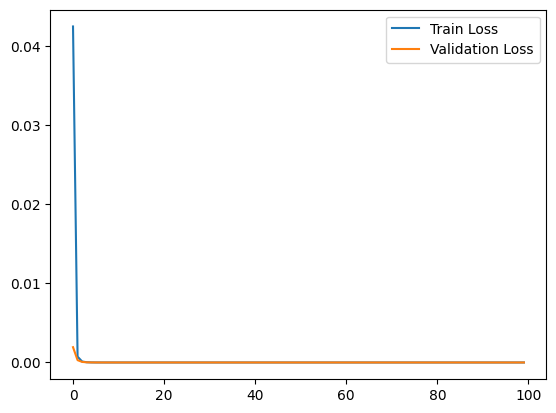

In [ ]:
import matplotlib.pyplot as plt

n_features = len(features)
n_products = len(item_cols)
hidden_size = 128

model = Autoencoder(n_features, n_products, hidden_size)

model, train_losses, val_losses = train_model(
    model, X_train, X_val, features, item_cols, 
    dataset=AEDataset, n_epochs=100, lr=1e-3, batch_size=64, device="cpu", patience=5, save_loc="./models/"
)

fig, ax = plt.subplots()
ax.plot(train_losses, label="Train Loss")
ax.plot(val_losses, label="Validation Loss")
ax.legend()
plt.show()

In [220]:
X = full_dataset[["date"] + features + target_cols]

model = Autoencoder(n_features, n_products, hidden_size)
model.load_state_dict(torch.load("./models/model.pth"))

preds = model.predict(X[features].astype(int), features, item_cols, batch_size=32, device="mps")
preds = pd.DataFrame(preds, columns=item_cols)
preds = (preds - X[item_cols]).abs().sum(axis=1).to_frame("error")
preds = preds.merge(X[target_cols], left_index=True, right_index=True)

In [221]:
preds.groupby("flag_missing_charges").mean()

,error
flag_missing_charges,
False,0.001056
True,0.000699


Epoch 1/100 - Train Loss: 0.00016812141506570682 - Val Loss: 0.0021851111135565864
Epoch 2/100 - Train Loss: 0.0001631445096930643 - Val Loss: 0.0021682525245460002
Epoch 3/100 - Train Loss: 0.0001608687877702642 - Val Loss: 0.002117681878824955
Epoch 4/100 - Train Loss: 0.0001591852872750614 - Val Loss: 0.0021369306555775723
Epoch 5/100 - Train Loss: 0.00015788963262077915 - Val Loss: 0.002100609021333094
Epoch 6/100 - Train Loss: 0.00015682751690460287 - Val Loss: 0.002064875417021848
Epoch 7/100 - Train Loss: 0.0001559232741643816 - Val Loss: 0.0020668569914581206
Epoch 8/100 - Train Loss: 0.00015515536054027561 - Val Loss: 0.0020695208562770146
Epoch 9/100 - Train Loss: 0.00015470160087146655 - Val Loss: 0.0020422923406680222
Epoch 10/100 - Train Loss: 0.00015414139808389313 - Val Loss: 0.0020418669566190997
Epoch 11/100 - Train Loss: 0.0001537056540236666 - Val Loss: 0.0020293562873597323
Epoch 12/100 - Train Loss: 0.00015345753468778433 - Val Loss: 0.002023178900464093
Epoch 13/1

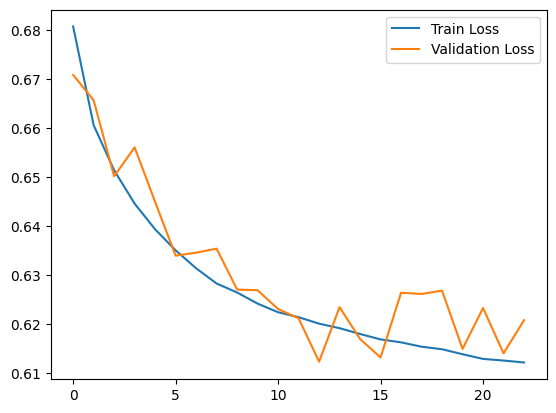

In [247]:
from imblearn.over_sampling import SMOTE

def train_model(
        model: nn.Module,
        X_train: torch.Tensor,
        X_val: torch.Tensor,
        features: list[str],
        targets: list[str],
        dataset: Dataset,
        criterion: nn.Module = nn.BCELoss,
        optimizer: torch.optim.Optimizer = torch.optim.Adam,
        n_epochs: int = 100,
        lr: float = 1e-3,
        batch_size: int = 32,
        device: str = "mps",
        patience: int = 5,
        save_loc: str = "./models/"
    ):
    model.to(device)
    optimizer = optimizer(model.parameters(), lr=lr)
    train_loader = DataLoader(dataset(X_train, features, targets), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset(X_val, features, targets), batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []
    best_val_loss = float("inf")
    patience_counter = 0
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            batch = inputs.float().to(device)
            output = model(batch)
            output = output.squeeze()
            loss = criterion(output, targets.float().to(device))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                batch = inputs.float().to(device)
                output = model(batch)
                output = output.squeeze()
                loss = criterion(output, targets.float().to(device))
                val_loss += loss.item()
            val_loss /= len(val_loader)
            val_losses.append(val_loss)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), save_loc + "model.pth")
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter == patience:
                    break

        print(f"Epoch {epoch + 1}/{n_epochs} - Train Loss: {train_loss / len(train_loader)} - Val Loss: {val_loss / len(val_loader)}")
    
    if os.path.exists(save_loc + "model.pth"):
        model.load_state_dict(torch.load(save_loc + "model.pth"))

    model.to("cpu")
    model.eval()

    return model, train_losses, val_losses

class Classifier(nn.Module):
    def __init__(
            self,
            n_features: int,
            hidden_size: int,
            dropout: float,
    ):
        super(Classifier, self).__init__()
        self.n_features = n_features
        self.hidden_size = hidden_size

        self.classifier = nn.Sequential(
            nn.Linear(n_features, hidden_size),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.classifier(x)
    
    def predict(self, X: pd.DataFrame, features: list[str], targets: list[str], batch_size: int = 32, device: str = "cpu") -> np.ndarray:
        self.to(device)
        loader = DataLoader(ClassifierDataset(X, features, targets), batch_size=batch_size, shuffle=False)
        predictions = []
        with torch.no_grad():
            for inputs, _ in loader:
                batch = inputs.float().to(device)
                output = self(batch)
                output = self.sigmoid(output).squeeze().to("cpu")
                output = output.squeeze()
                predictions.append(output)
        predictions = torch.cat(predictions, dim=0)
        self.to("cpu")
        return predictions.detach().numpy()
    

class ClassifierDataset(Dataset):
    
    def __init__(self, X: pd.DataFrame, features: list[str], targets: list[str]):
        self.X = X[features].values
        self.y = X[targets].values

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # return torch.tensor(self.X[idx])
        return (
            torch.tensor(self.X[idx]), torch.tensor(self.y[idx])
        )
    
X = full_dataset[["date"] + features + target_cols]
dates = X["date"].unique()
X.set_index("date", inplace=True)

val_split = 0.7
test_split = 0.8
train_dates = dates[:int(len(dates) * val_split)]
val_dates = dates[int(len(dates) * val_split):int(len(dates) * test_split)]
test_dates = dates[int(len(dates) * test_split):]

X_train = X.loc[train_dates].astype(int)
X_val = X.loc[val_dates].astype(int)
X_test = X.loc[test_dates].astype(int)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train[features], X_train[target_cols[0]])

X_train = pd.concat([X_train_resampled, y_train_resampled], axis=1)

pos_weight = torch.tensor([1.0 / X_train[target_cols[0]].mean(), 1.0 / (1 - X_train[target_cols[0]].mean())][0])
    
model = Classifier(n_features, 10, 0.1)

model, train_losses, val_losses = train_model(
    model, X_train, X_val, features, target_cols[0], 
    criterion=nn.BCEWithLogitsLoss(),#pos_weight=pos_weight), 
    optimizer=torch.optim.Adam,
    dataset=ClassifierDataset, n_epochs=100, lr=1e-4, batch_size=64, device="cpu", patience=10, save_loc="./models/"
)

fig, ax = plt.subplots()
ax.plot(train_losses, label="Train Loss")
ax.plot(val_losses, label="Validation Loss")
ax.legend()
plt.show()

In [252]:
train_preds = model.predict(X_train[features + target_cols].astype(int), features, target_cols[0], batch_size=32, device="cpu")
val_preds = model.predict(X_val[features + target_cols].astype(int), features, target_cols[0], batch_size=32, device="cpu")
test_preds = model.predict(X_test[features + target_cols].astype(int), features, target_cols[0], batch_size=32, device="cpu")


print("Train Metrics")
print(metrics(X_train[target_cols[0]], train_preds >= 0.5), "\n")
print("Validation Metrics")
print(metrics(X_val[target_cols[0]], val_preds >= 0.5), "\n")
print("Test Metrics")
print(metrics(X_test[target_cols[0]], test_preds >= 0.5), "\n")

Train Metrics
{'accuracy': 0.6529, 'recall': 0.6546, 'precision': 0.6524, 'f1': 0.6535} 

Validation Metrics
{'accuracy': 0.6415, 'recall': 0.4884, 'precision': 0.0659, 'f1': 0.1162} 

Test Metrics
{'accuracy': 0.6381, 'recall': 0.5555, 'precision': 0.0746, 'f1': 0.1315} 



In [253]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train[features], X_train[target_cols[0]])

train_preds = rf.predict(X_train[features])
val_preds = rf.predict(X_val[features])
test_preds = rf.predict(X_test[features])

print("Train Metrics")
print(metrics(X_train[target_cols[0]], train_preds), "\n")
print("Validation Metrics")
print(metrics(X_val[target_cols[0]], val_preds), "\n")
print("Test Metrics")
print(metrics(X_test[target_cols[0]], test_preds), "\n")

Train Metrics
{'accuracy': 0.653, 'recall': 0.6951, 'precision': 0.6411, 'f1': 0.667} 

Validation Metrics
{'accuracy': 0.5996, 'recall': 0.5137, 'precision': 0.0617, 'f1': 0.1101} 

Test Metrics
{'accuracy': 0.6039, 'recall': 0.5703, 'precision': 0.0698, 'f1': 0.1244} 

